# EDS2CHEM example

The present notebook showcases the EDS2CHEM approach developed in close collaboration with Sarah Shi (https://github.com/sarahshi) for calibrating intensity maps. The present approach utilises a simple MCMC approach to fit a handful of parameters. Profiles are defined by their start and end points (samples and fitted) and assumed to be composed of equidistant points. Next, we define a region of pixels around the profile and project nearby pixels in a given box at a given angle from the profile - both of these parameters are also sampled and fitted using MCMC - in order to aid reduce the random noise in the intensity maps. A straight line fit between the intensity values and the quantified profiles are the last two parameters fitted and are indeed the two most coveted values. These can be used to calibrate the entire intensity map itself.

Note that in this example, we are not running the MCMC routine for as long as we perhaps should to fully explore the parameter space as it is just an illustration.

In [7]:
import os
import numpy as np
import pandas as pd
#own code:
import MCMC_emcee as mcmc
import matplotlib.pyplot as plt
def calc_an(CaO, Na2O):
    return ((CaO/56.0774)/(CaO/56.0774+2*Na2O/61.9789))*100

Here we define the region and an initial guess that will be used to find the max likelihood estimates:

In [2]:
##############################################
##############################################
plag_crysts = ['Sample424_2_plag5']
regions =  [1200,1550, 1300,1650]
params_list = [150., 250., 200., 180., 5., -1., 1., 90.]
##############################################
##############################################

All files are loaded and and processed to be the correct format:

In [5]:
import chardet

#load in the quantified profile data
with open("0424/Sample424_2_0_oxide.txt", 'rb') as f:
    result = chardet.detect(f.read()) 

DF_NEW = pd.read_csv("0424/Sample424_2_0_oxide.txt", skiprows=[i for i in range(51)], delimiter = "\t",
                        encoding = result['encoding'], index_col= ['Comment', 'DataSet/Point'],)

samplename = DF_NEW.index.levels[0]


#calculate anorthite content from elements
DF_NEW["Anorthite"] = calc_an(DF_NEW["CaO"].to_numpy(), DF_NEW["Na2O"].to_numpy())


#load in the intensity map
res = np.load("0424/0424_2all_the_data.npz", allow_pickle = True)
gauss_plag_pca, ol_pca_img, cpx_pca_img, glass, spinel = res["scores"] 

#set up the data - cut out the region from the whole map to reduce computational cost
region = regions
xl_pca1 = gauss_plag_pca[region[0]:region[1], region[2]:region[3]]
plag1 = DF_NEW.loc[plag_crysts]


params1 = np.asarray(params_list)

# minimum and maximum parameter values 
parameter_delta = [50.,50.,50.,50.]
pmin1 =   np.array([params1[0] - parameter_delta[0] ,params1[1] - parameter_delta[1],params1[2] - parameter_delta[2],
                    params1[3] - parameter_delta[3],  1., -100., -100., 0.0])
pmax1 =   np.array([params1[0] + parameter_delta[0] ,params1[1] + parameter_delta[1],params1[2] + parameter_delta[2],
                    params1[3] + parameter_delta[3],    30., 0., 100., 180.0])
files = plag_crysts
an_1 = plag1.Anorthite.values / 100

#get rid of spurious points manually - this is where a crack was hit
an_1[5:7] = 0.83

# this is where the magic happens!
mc3_output1 = mcmc.MCMC_run(xl_pca1, an_1, an_1*0.01, params = params1,
                pmin = pmin1, pmax = pmax1, return_ = True, name = plag_crysts)



[ 1.49928516e+02  2.49985573e+02  1.99958620e+02  1.80005575e+02
  5.09740010e+00 -2.75637863e-03  8.15811637e-01  8.99414192e+01]


100%|██████████| 10000/10000 [2:51:37<00:00,  1.03s/it]      


This is the intensity map region we use here:

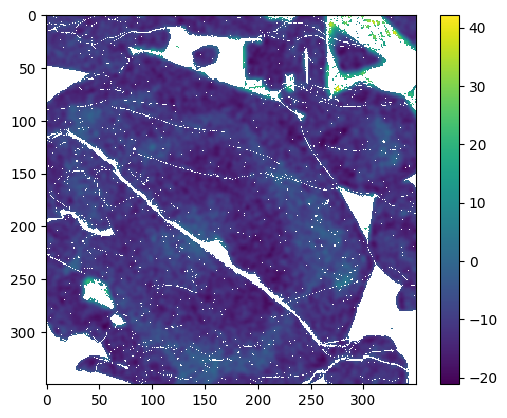

In [10]:
plt.imshow(xl_pca1, interpolation="none")
plt.colorbar()

And this is the profile we're fitting:

Text(0.5, 0, 'Distance (steps)')

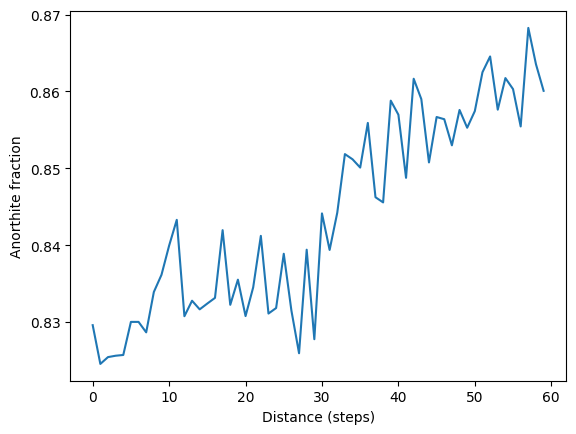

In [11]:
plt.plot(range(len(an_1)), an_1)
plt.ylabel("Anorthite fraction")
plt.xlabel("Distance (steps)")

Get thinned posterior samples and visualise them using corner plot:

In [17]:
samples = mc3_output1.get_chain(discard=1000, thin = 18, flat = True)

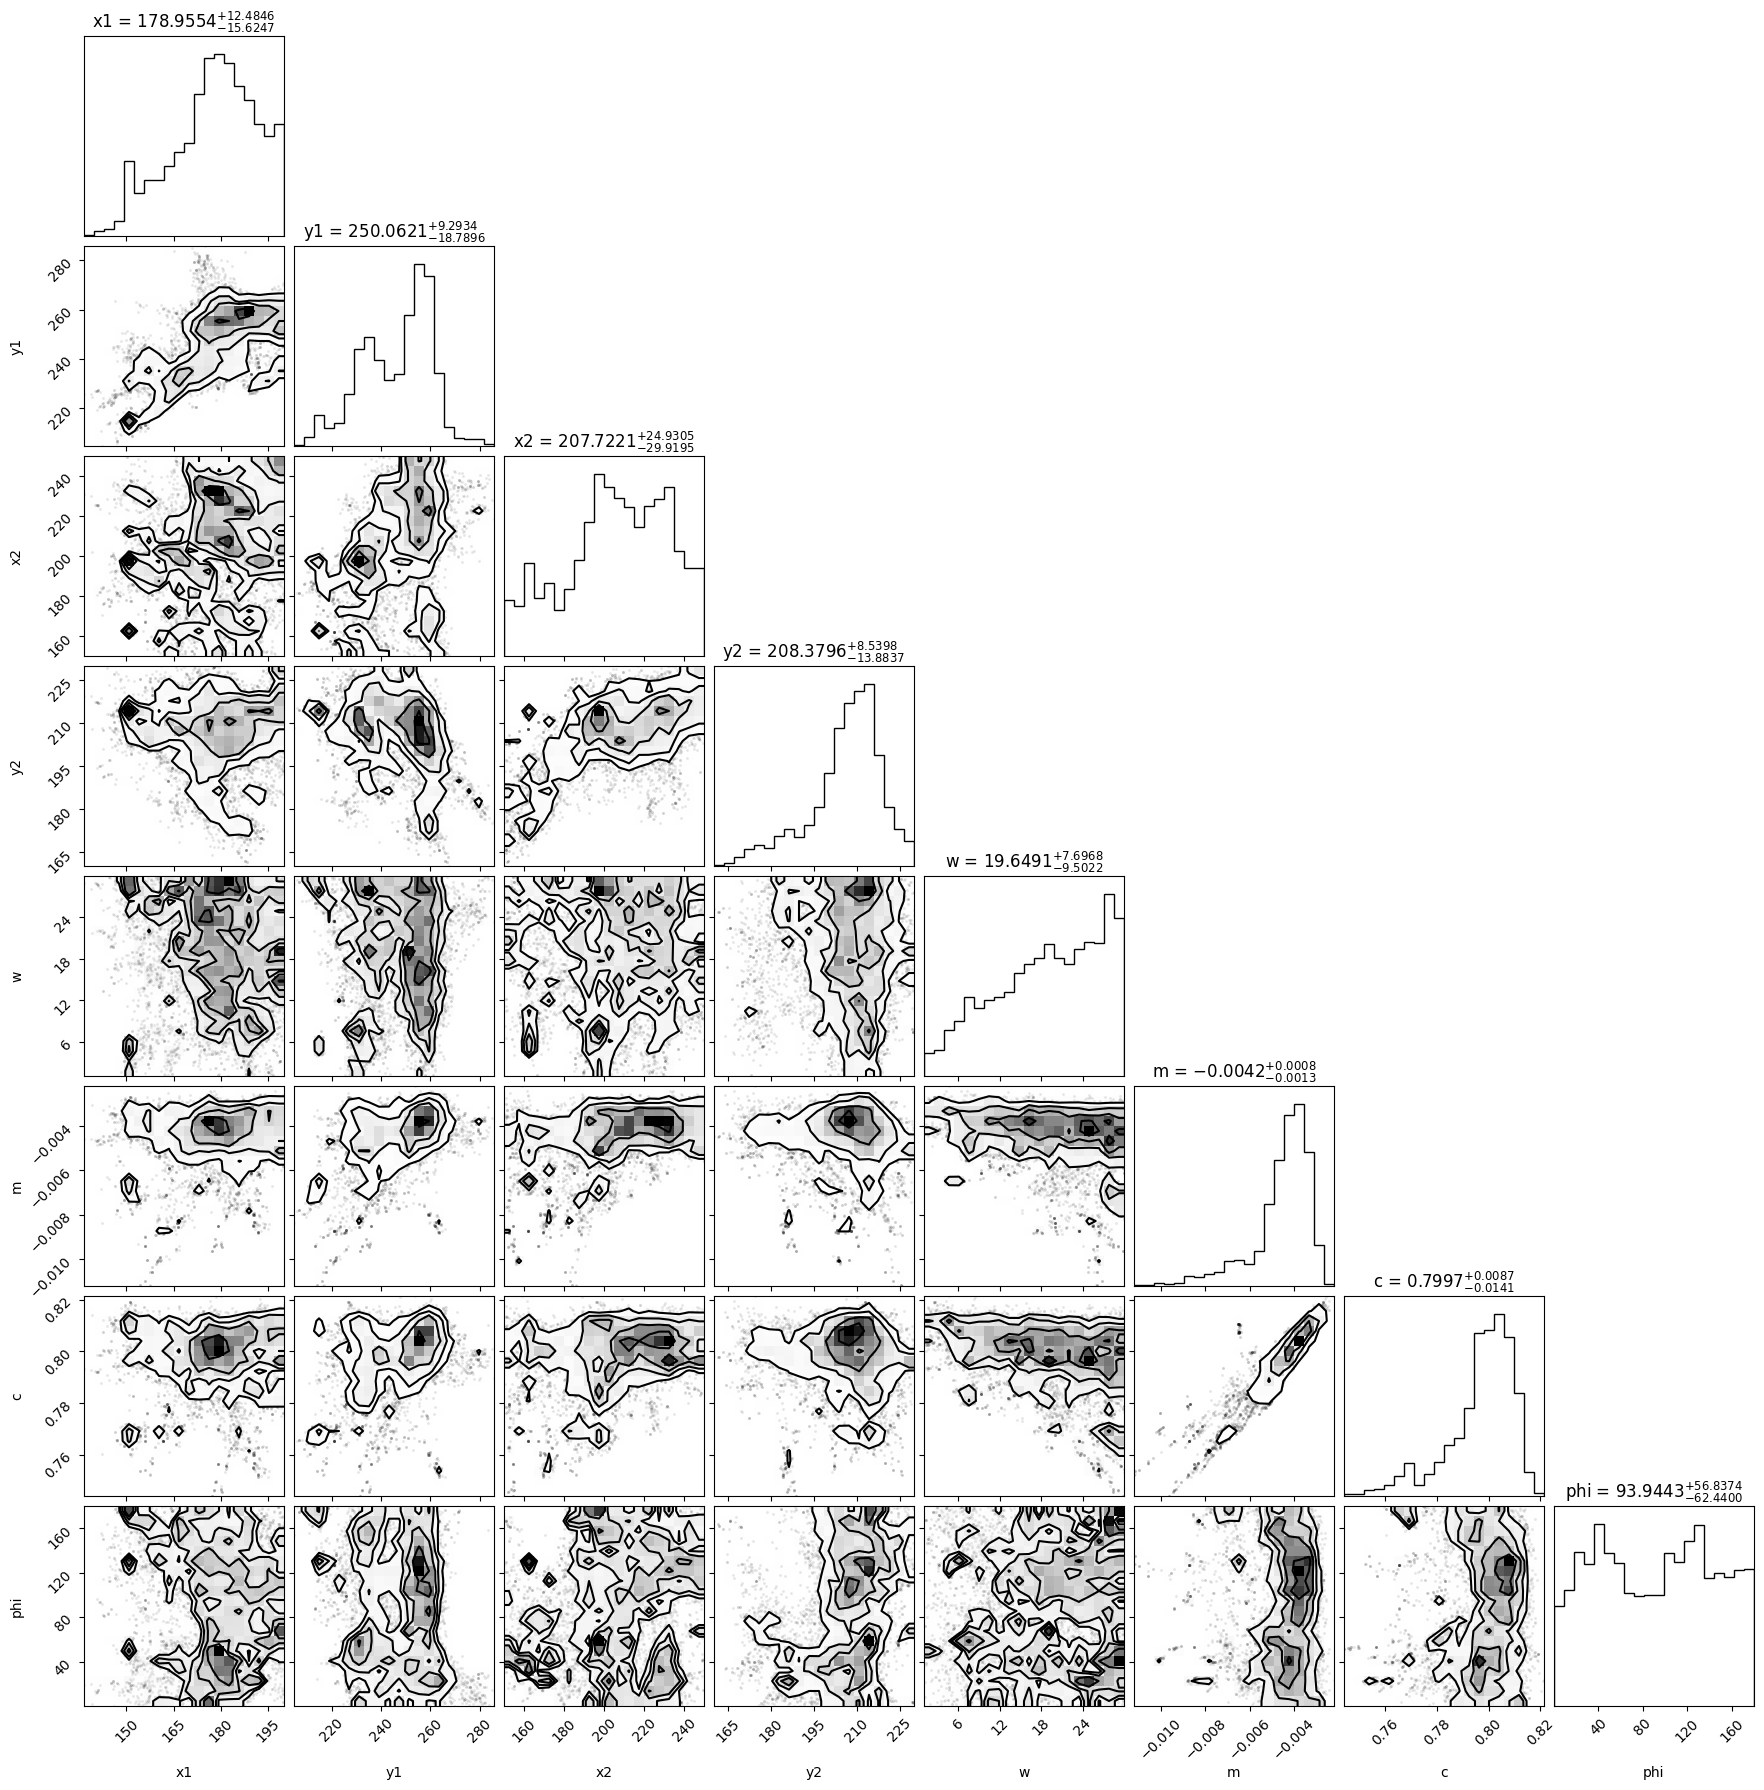

In [27]:
import corner
_ = corner.corner(samples, labels = ["x1","y1", "x2", "y2", "w", "m", "c", "phi"], show_titles=True, title_fmt=".4f")

Let's visualise the calibration curve:

In [28]:
xdata = np.linspace(-22, 6, 250)
ysamples = [xdata[i]*samples[:,5] + samples[:,6] for i in range(len(xdata))]

In [29]:
ye1 = np.quantile(np.sort(ysamples, axis = 0), 0.16, axis = 1)
ye2 = np.quantile(np.sort(ysamples, axis = 0), 0.84, axis = 1)
ye3 = np.quantile(np.sort(ysamples, axis = 0), 0.025, axis = 1)
ye4 = np.quantile(np.sort(ysamples, axis = 0), 0.975, axis = 1)

Text(0.5, 0, 'PC1 score')

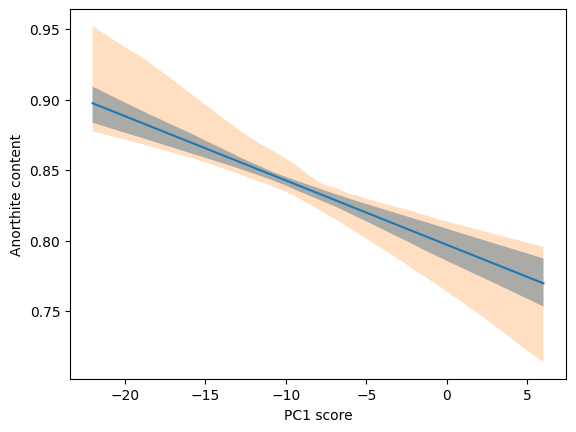

In [30]:
plt.plot(xdata,np.mean(ysamples, axis = 1))
plt.fill_between(xdata[::-1], ye2, ye1, alpha = 0.5)
plt.fill_between(xdata[::-1], ye4, ye3, alpha = 0.25)
plt.ylabel("Anorthite content")
plt.xlabel("PC1 score")

Let's take a look at the samples forming the joint posterior:

In [31]:
from MCMC_emcee import align
model_res = []
for item in samples:
    model = align(xl_pca1, len(an_1), item)
    model_res.append(model)
model_res = np.asarray(model_res)

yes1 = []
yes2 = []
yes3 = []
yes4 = []
for i in range(model_res.shape[1]):
    yes1.append(np.quantile(np.sort(model_res[:,i]), 0.16))
    yes2.append(np.quantile(np.sort(model_res[:,i]), 0.84))
    yes3.append(np.quantile(np.sort(model_res[:,i]), 0.025))
    yes4.append(np.quantile(np.sort(model_res[:,i]), 0.975))

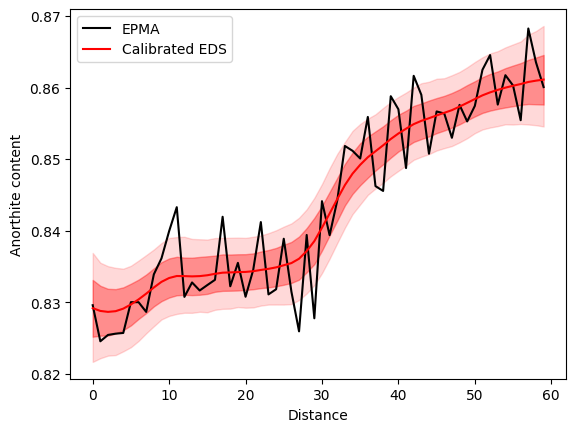

In [32]:
plt.plot(range(len(an_1)), an_1, 'k', label = "EPMA")
plt.plot(range(len(model)), np.mean(model_res, axis = 0), 'r', label = "Calibrated EDS")
plt.fill_between(range(len(model)), yes1, yes2, color = 'r', alpha = 0.35,)
plt.fill_between(range(len(model)), yes3, yes4, color = 'r', alpha = 0.15)
plt.ylabel("Anorthite content")
plt.xlabel("Distance")
plt.legend()


Text(0.5, 0, 'Distance')

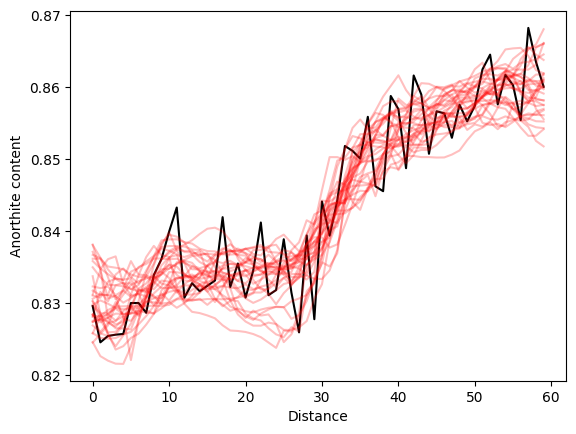

In [33]:
import matplotlib.pyplot as plt
plt.plot(range(len(an_1)), an_1, 'k', label = "EPMA")
inds = np.random.randint(0, 1000, 30)
for _ in range(30):
    plt.plot(range(len(model)), model_res[inds[_],:], 'r', label = "Calibrated EDS", alpha = 0.25)

plt.ylabel("Anorthite content")
plt.xlabel("Distance")